<a href="https://colab.research.google.com/github/Varshnisv/Google_Play_Store/blob/main/PROJECT_COVID_19_COMPLETED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all necessary libraries(numpy, os, cv2, matplolib, keras)
import numpy as np
import os
import cv2
from keras import layers
from keras.layers import Input, Dense, Add,Activation, AveragePooling2D, BatchNormalization, Flatten, Conv2D, MaxPooling2D, Dropout, ZeroPadding2D
from keras.models import Model, load_model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.initializers import glorot_uniform
from keras import regularizers
import scipy.misc
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_data_gen = ImageDataGenerator(rotation_range=50,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)
valid_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    zoom_range=0.3,
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    fill_mode='constant',
                                    cval=0,
                                    rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

In [ ]:
dataset_dir = os.path.join("/content/drive/MyDrive/Covid_New_Pneumonia/Dataset")

Batch_size = 8
img_h = 256
img_w = 256
num_classes=3

classes = ['Covid','Normal','Viral Pneumonia']
# Training
SEED = 1234
import tensorflow as tf
tf.random.set_seed(SEED)

training_dir = os.path.join(dataset_dir, 'train')

In [ ]:
training_dir

'/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train'

In [ ]:
print(os.path.join(dataset_dir, 'train'))

/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train


In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')

import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [ ]:
def list_images(basePath, contains=None):
    # return the set of files that are valid
    return list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=contains)

def list_files(basePath, validExts=(".jpg", ".jpeg", ".png", ".bmp"), contains=None):
    # loop over the directory structure
    for (rootDir, dirNames, filenames) in os.walk(basePath):
        # loop over the filenames in the current directory
        for filename in filenames:
            # if the contains string is not none and the filename does not contain
            # the supplied string, then ignore the file
            if contains is not None and filename.find(contains) == -1:
                continue

            # determine the file extension of the current file
            ext = filename[filename.rfind("."):].lower()

            # check to see if the file is an image and should be processed
            if ext.endswith(validExts):
                # construct the path to the image and yield it
                #imagePath = os.path.join(rootDir, filename).replace(" ", "\\ ")
                imagePath = os.path.join(rootDir, filename)
                yield imagePath

def load_images(directory='', size=(64,64)):
    images = []
    labels = []  # Integers corresponding to the categories in alphabetical order
    label = 0

    imagePaths = list(list_images(directory))

    for path in imagePaths:

        if not('OSX' in path):

            path = path.replace('\\','/')
            print(path)
            image = cv2.imread(path) #Reading the image with OpenCV
            image = cv2.resize(image,size) #Resizing the image, in case some are not of the same size

            images.append(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    return images


In [ ]:
images=load_images('/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid')

/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/010.png
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/02.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/012.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/015.jpg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/01.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/019.png
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/048.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/026.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/050.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/031.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/046.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/021.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/032.jpeg
/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/train/Covid/049.jp

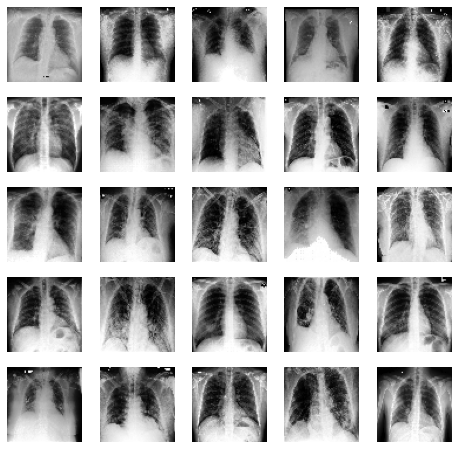

In [ ]:
_,ax = plt.subplots(5,5, figsize = (8,8))
for i in range(5):
    for j in range(5):
        ax[i,j].imshow(images[5*i+j])
        ax[i,j].axis('off')

In [ ]:
class GAN():
    def __init__(self):
        self.img_shape = (64, 64, 3)

        self.noise_size = 100

        optimizer = Adam(0.0002,0.5)

        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='categorical_crossentropy',
                                   optimizer=optimizer,
                                   metrics=['accuracy'])

        self.generator = self.build_generator()
        self.generator.compile(loss='categorical_crossentropy', optimizer=optimizer)

        self.combined = Sequential()
        self.combined.add(self.generator)
        self.combined.add(self.discriminator)

        self.discriminator.trainable = False

        self.combined.compile(loss='categorical_crossentropy', optimizer=optimizer)

        self.combined.summary()


    def build_generator(self):
        epsilon = 0.00001 #
        noise_shape = (self.noise_size,)

        model = Sequential()

        model.add(Dense(4*4*512, activation='linear', input_shape=noise_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Reshape((4, 4, 512)))

        model.add(Conv2DTranspose(512, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(256, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(128, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(64, kernel_size=[4,4], strides=[2,2], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))
        model.add(BatchNormalization(momentum=0.9, epsilon=epsilon))
        model.add(LeakyReLU(alpha=0.2))

        model.add(Conv2DTranspose(3, kernel_size=[4,4], strides=[1,1], padding="same",
                                  kernel_initializer= keras.initializers.TruncatedNormal(stddev=0.02)))


        model.add(Activation("tanh"))

        model.summary()

        noise = Input(shape=noise_shape)
        img = model(noise)

        return Model(noise, img)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(128, (3,3), padding='same', input_shape=self.img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.2))

        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(Conv2D(128, (3,3), padding='same'))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(3,3)))
        model.add(Dropout(0.3))

        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1, activation='sigmoid'))

        model.summary()

        img = Input(shape=self.img_shape)
        validity = model(img)

        return Model(img, validity)

    def train(self, epochs, batch_size=128, metrics_update=50, save_images=100, save_model=2000):

        X_train = np.array(images)
        X_train = (X_train.astype(np.float32) - 127.5) / 127.5

        half_batch = int(batch_size / 2)

        mean_d_loss=[0,0]
        mean_g_loss=0

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], half_batch)
            imgs = X_train[idx]

            noise = np.random.normal(0, 1, (half_batch, self.noise_size))
            gen_imgs = self.generator.predict(noise)

            d_loss = 0.5 * np.add(self.discriminator.train_on_batch(imgs, np.ones((half_batch, 1))),
                                  self.discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1))))

            # Training the generator
            noise = np.random.normal(0, 1, (batch_size, self.noise_size))

            valid_y = np.array([1] * batch_size)
            g_loss = self.combined.train_on_batch(noise, valid_y)

            mean_d_loss[0] += d_loss[0]
            mean_d_loss[1] += d_loss[1]
            mean_g_loss += g_loss


            if epoch % metrics_update == 0:
                print ("%d [Discriminator loss: %f, acc.: %.2f%%] [Generator loss: %f]" % (epoch, mean_d_loss[0]/metrics_update, 100*mean_d_loss[1]/metrics_update, mean_g_loss/metrics_update))
                mean_d_loss=[0,0]
                mean_g_loss=0


            if epoch % save_images == 0:
                self.save_images(epoch)


            if epoch % save_model == 0:
                self.generator.save("generator_%d" % epoch)
                self.discriminator.save("discriminator_%d" % epoch)
    def save_images(self, epoch):
        noise = np.random.normal(0, 1, (25, self.noise_size))
        gen_imgs = self.generator.predict(noise)

        # Rescale from [-1,1] into [0,1]
        gen_imgs = 0.5 * gen_imgs + 0.5

        fig, axs = plt.subplots(5,5, figsize = (8,8))

        for i in range(5):
            for j in range(5):
                axs[i,j].imshow(gen_imgs[5*i+j])
                axs[i,j].axis('off')

        plt.show()

        #fig.savefig("animeGenerated/Faces_%d.png" % epoch)
        #plt.close()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 128)       3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 batch_normalization_1 (Batc  (None, 64, 64, 128)      512       
 hNormalization)                                        

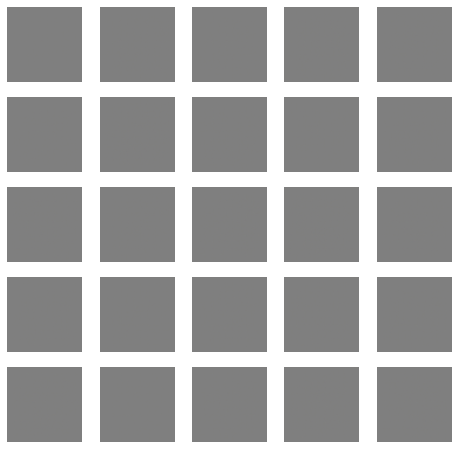

4/4 [==============================] - 0s 18ms/step


In [ ]:
gan=GAN()
gan.train(epochs=200, batch_size=256, metrics_update=200, save_images=1000, save_model=15000)

In [ ]:
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               target_size=(256, 256),
                                               batch_size=Batch_size,
                                               classes=classes,
                                               class_mode='sparse',
                                               shuffle=True,
                                               seed=SEED)  # targets are directly converted into one-hot vectors

Found 251 images belonging to 3 classes.


In [ ]:

# Test
test_dir = os.path.join(dataset_dir, 'test')
test_gen = test_data_gen.flow_from_directory(test_dir,
                                             target_size=(256, 256),
                                             batch_size=10,
                                             shuffle=False,
                                             seed=SEED,
                                             class_mode=None,
                                             )
CLASS_NAMES = np.array(['Covid','Normal','Viral Pneumonia'], dtype='<U10')

Found 66 images belonging to 3 classes.


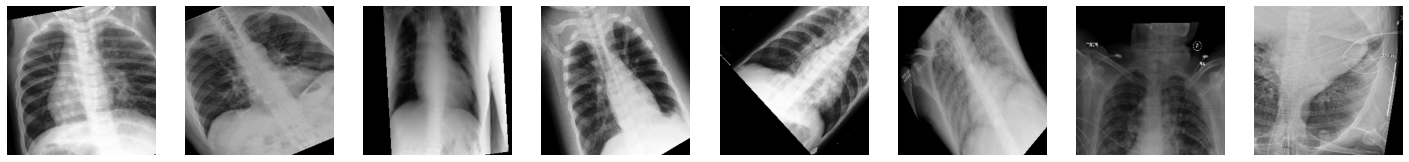

In [ ]:
import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(25,20))
  for n in range(8):
      ax = plt.subplot(1,8,n+1)
      plt.imshow(image_batch[n])
      #plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_gen)
show_batch(image_batch, label_batch)




In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Adam

In [ ]:
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.models as M
from tensorflow.keras.optimizers import Adam

In [ ]:
ResNet_model = tf.keras.applications.ResNet152V2(weights='imagenet', include_top=False, input_shape=(img_h, img_w, 3))
for layer in ResNet_model.layers[:-15]:
    layer.trainable = False

x = ResNet_model.output
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)
x_s = x
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)
x = L.Conv1D(filters = 8, kernel_size = 3, padding = "same", strides = 1)(x)
x = L.BatchNormalization()(x)
x = L.Activation("relu")(x)
x = L.Flatten()(x)
x = Dense(20, activation = "relu")(x)
x = tf.expand_dims(x, axis=-1)
x = L.LSTM(8,return_sequences=True)(x)
x = L.Flatten()(x)
x = L.BatchNormalization()(x)
x = L.Dropout(0.01)(x)
output = L.Dense(3, activation = "softmax")(x)
model = Model(ResNet_model.input,output)


#model.summary()
loss = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss=loss, metrics= ['accuracy'])

234545216/234545216 [==============================] - 11s 0us/step


In [ ]:
transfer_learning_history = model.fit_generator(generator=train_gen,
                   epochs=200)

Epoch 1/200
32/32 [==============================] - 125s 3s/step - loss: 1.0686 - accuracy: 0.4303
Epoch 2/200
32/32 [==============================] - 14s 430ms/step - loss: 0.8002 - accuracy: 0.5857
Epoch 3/200
32/32 [==============================] - 14s 432ms/step - loss: 0.7225 - accuracy: 0.6574
Epoch 4/200
32/32 [==============================] - 14s 432ms/step - loss: 0.5944 - accuracy: 0.7490
Epoch 5/200
32/32 [==============================] - 14s 431ms/step - loss: 0.5381 - accuracy: 0.7809
Epoch 6/200
32/32 [==============================] - 14s 436ms/step - loss: 0.6644 - accuracy: 0.7171
Epoch 7/200
32/32 [==============================] - 14s 444ms/step - loss: 0.5250 - accuracy: 0.7769
Epoch 8/200
32/32 [==============================] - 14s 441ms/step - loss: 0.4806 - accuracy: 0.8287
Epoch 9/200
32/32 [==============================] - 14s 429ms/step - loss: 0.4656 - accuracy: 0.8207
Epoch 10/200
32/32 [==============================] - 14s 433ms/step - loss: 0.4709 

In [ ]:
model.save('model.h5')

In [ ]:
import matplotlib.pyplot as plt
acc = transfer_learning_history.history['accuracy']
#val_acc = transfer_learning_history.history['val_accuracy']
loss = transfer_learning_history.history['loss']
#val_loss = transfer_learning_history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
#plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
#plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
test_gen.reset()
pred=model.predict(test_gen,verbose=1)
y_pred=pred.argmax(axis=1)

7/7 [==============================] - 46s 7s/step


In [ ]:
STEP_SIZE_TEST=test_gen.n//test_gen.batch_size
train_gen.reset()
pred=model.predict(train_gen,verbose=1)
y_trpred=pred.argmax(axis=1)

32/32 [==============================] - 16s 410ms/step


In [ ]:
import pandas as pd
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
filenames=train_gen.filenames
FN=[]
for i in filenames:
  FN.append(i)
y_ttrain = []
for i in filenames:
  y_ttrain.append(i.split('/')[0][0])


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_ttrain= label_encoder.fit_transform(y_ttrain)

TRAINIG RESULTS: 


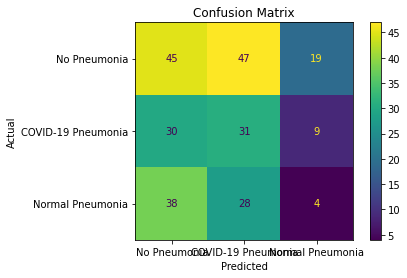

ACCURACY SCORE:
0.3187
CLASSIFICATION REPORT:
              precision    recall  f1-score     support
0              0.398230  0.405405  0.401786  111.000000
1              0.292453  0.442857  0.352273   70.000000
2              0.125000  0.057143  0.078431   70.000000
accuracy       0.318725  0.318725  0.318725    0.318725
macro avg      0.271894  0.301802  0.277497  251.000000
weighted avg   0.292531  0.318725  0.297799  251.000000


In [ ]:
#from sklearn.metrics import confusion_matrix
#import seaborn as sns
#CM = confusion_matrix(y_ttrain,y_trpred)
#CM

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report,ConfusionMatrixDisplay

print("TRAINIG RESULTS: \n===============================")
clf_report = pd.DataFrame(classification_report(y_ttrain, y_trpred, output_dict=True))
    #print(f"CONFUSION MATRIX:\n{confusion_matrix(y_train, y_train_pred)}")
cm=confusion_matrix(y_ttrain, y_trpred)
cm_obj=ConfusionMatrixDisplay(cm,display_labels={'COVID-19 Pneumonia','No Pneumonia','Normal Pneumonia'})
cm_obj.plot()
cm_obj.ax_.set(title='Confusion Matrix',xlabel='Predicted',ylabel='Actual')
plt.show()
print(f"ACCURACY SCORE:\n{accuracy_score(y_ttrain, y_trpred):.4f}")
print(f"CLASSIFICATION REPORT:\n{clf_report.T}")

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_ttrain, y_trpred))

              precision    recall  f1-score   support

           0       0.40      0.41      0.40       111
           1       0.29      0.44      0.35        70
           2       0.12      0.06      0.08        70

    accuracy                           0.32       251
   macro avg       0.27      0.30      0.28       251
weighted avg       0.29      0.32      0.30       251



In [ ]:
import pandas as pd
labels = train_gen.class_indices
labels = dict((v,k) for k,v in labels.items())
filenames=test_gen.filenames
FN=[]
for i in filenames:
  FN.append(i)
y_test = []
for i in filenames:
  y_test.append(i.split('/')[0][0])


In [ ]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
y_test= label_encoder.fit_transform(y_test)
print(y_test)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
CM = confusion_matrix(y_test,y_pred)
CM

array([[23,  3,  0],
       [ 0, 18,  2],
       [ 0, 11,  9]])

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.88      0.94        26
           1       0.56      0.90      0.69        20
           2       0.82      0.45      0.58        20

    accuracy                           0.76        66
   macro avg       0.79      0.74      0.74        66
weighted avg       0.81      0.76      0.76        66



In [ ]:
from sklearn import metrics
traccuracy=metrics.accuracy_score(y_test, y_pred)
trf1_score=metrics.f1_score(y_test, y_pred,average='macro')
trprecision_score=metrics.precision_score(y_test, y_pred,average='macro')
trrecall_score=metrics.recall_score(y_test, y_pred,average='macro')
trkappa_score=metrics.cohen_kappa_score(y_test, y_pred)
trMAE=metrics.mean_absolute_error(y_test, y_pred)
trMSE=metrics.mean_squared_error(y_test, y_pred)
trR_square=metrics.r2_score(y_test, y_pred)

In [ ]:
trdata =[traccuracy,trf1_score,trprecision_score,trrecall_score,trkappa_score,trMAE,trMSE,trR_square]
trvalues = ['Accuracy','F1_score','Precision','Recall','kappa_score','MAE','MSE','R_square']
trdatas=zip(trvalues,trdata)
trFinal = pd.DataFrame(trdatas,columns=['Meaurement','values'])
trFinal

,Meaurement,values
0,Accuracy,0.757576
1,F1_score,0.737243
2,Precision,0.793561
3,Recall,0.744872
4,kappa_score,0.635611
5,MAE,0.242424
6,MSE,0.242424
7,R_square,0.648000


In [ ]:

image = tf.keras.preprocessing.image.load_img("/content/drive/MyDrive/Covid_New_Pneumonia/Dataset/test/Viral Pneumonia/0103.jpeg",target_size= (256,256,3))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.array([input_arr])  # Convert single image to a batch.
predictions = model.predict(input_arr)
print(np.argmax(predictions ,axis=1))
preds = np.argmax(predictions ,axis=1)
if preds == 0:
  print("The Predicted result of the given image : COVID Pneumonia")
elif preds ==1:
  print("The Predicted result of the given image : No Pneumonia")
else:
  print("The Predicted result of the given image : Normal Pneumonia")

[2]
The Predicted result of the given image : Normal Pneumonia
